### Tutorial 1
## Data preparation
In this Notebook, we show how one can generate data in order train a learned correction for the forward operator in photon-counting CT. The code below reproduces some of the results presented in [1]. 

[1]: Photon-Counting CT Reconstruction with a Learned
Forward Operator. E.Ström, M.Persson, A.Eguizabal and O.Öktem. IEEE transactions on computational imaging, 2022.

In [1]:
# Import Session
from learned_reconstruction.learning_session import *
from learned_reconstruction.operator_modules import *
from learned_reconstruction.plots import *
from tools.logger import EventTracker
import matplotlib.pyplot as plt
import torch
import os

The training and evaluation is made using an instance of `FwdBwdSession`. Apart from hyper parameter settings, `FwdBwdSession` requires a number of session-specific variables:
* `detector_settings_path` Path to the detector settings file. The detector settings can be altered (see `TUT_detector_settings.ipynb`) the settings define the resolution of the phantoms and sinograms:
    * Phantoms are (1, M, W, H) pytorch tensors. M is number of basis materials, W is pixel width, H is height.
    * Sinograms are (1, B, D, A) pytorch tensors. B is number of energy bins, D is number of detectors, A is number of angles.
* `session_path` Path where data from the sessions is stored. This folder can require a lot of space if many checkpoints are made throughout training. The session will store training losses, current parameter values and the like. The session path itself requires a number of subfolders with specific names:
    * `data_test` contains phantoms named `phantom_test_N.Tensor`.
    * `data_init` contains phantoms named `phantom_N.Tensor` where `N` is a whole number.
    * `data_target` contains phantoms named `target_phantom_N.Tensor`, and sinograms named `target_sinogram_N.Tensor`.
    The phantom `phantom_N.Tensor` should be the initial guess in an iterative method that aims at reconstructing `target_phantom_N.Tensor` from the noisy measurement `target_sinogram_N.Tensor`. The test phantoms are unrelated.
* `data_loading_path` Path where the training data is stored for access during training, for example an SSD.

We need to make sure that the above paths exist before creating a new session. Here's an example of how one can do this using the available library and a file containing only phantoms. We begin by creating the session directory. This is where all sessions will be stored.

In [9]:
# Choose device to run training and testing on.
device = "cuda"

# Create session directory
ses_path = "sessions/session_kits/"
os.makedirs(ses_path, exist_ok=True)
os.makedirs(ses_path+"data_init/", exist_ok=True)
os.makedirs(ses_path+"data_target/", exist_ok=True)
os.makedirs(ses_path+"data_test/", exist_ok=True)

# Make secret directory for data that will not be used in training.
os.makedirs(ses_path+"data_secret/", exist_ok=True)

# Create directory for quick loading into working memory
data_path = "data/ct_session_data/"
os.makedirs(data_path, exist_ok=True)

Next, we load data, split it into training and test, initialise and store in the correct folders. The resolution of the data is too high for the simulation capacity in this study. We create a simple max-pool operation to downsample the data into 128x128 images. The maxpool will ensure crisp edges, which are an important feature to preserve (it is exactly the blurring effect that we try to counteract in this work)

In [10]:
# Define function to store the phantoms
def store_separate(tensor, path, serial_name):
    for i in range(tensor.shape[0]):
        torch.save(tensor[None, i, :, :, :].clone(), f"{path}{serial_name}{i}.Tensor")

def downsample():
    # Downsample phantoms using max pool
    phantoms = torch.load("data/kits_phantoms.pt")
    downSampler = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
    phantoms = downSampler(phantoms)
    #assert (phantoms.shape[2] == 128) and (phantoms.shape[3] == 128)
    torch.save(phantoms, "data/kits_phantoms_256.pt")

Create measurements using simulated forward operator with poisson noise. We isolate this inside a function as well, to avoid unnecessary memory usage.

In [11]:
ntrain = 100
ntest = 100
nsecret = 100

img_w = 256
n_det = 512
n_ang = 512
    

def split_normalise_and_save_phantoms():
    # Seed
    seed = 0
    torch.manual_seed(seed)
    
    # Load data
    phantoms = torch.load("data/kits_phantoms_256.pt")
    
    # Normalise channels, divide by channel max
    chmax = [phantoms[:,i,:,:].max() for i in range(3)]
    for i in range(3):
        phantoms[:,i,:,:] /= chmax[i]

    
    # Shuffle data 
    idx_shuffled = torch.randperm(phantoms.shape[0])
    phantoms = phantoms[idx_shuffled, :, :, :]
    
    train = phantoms[:ntrain, :, :, :]
    test = phantoms[ntrain:(ntrain+ntest), :, :, :]
    secret = phantoms[(ntrain+ntest):(ntrain+ntest+nsecret),:,:,:]

    # Store true phantoms in target folder
    store_separate(train, ses_path + "/data_target/", "target_phantom_")

    # Store other phantoms in test folder
    store_separate(test, ses_path + "/data_test/", "phantom_test_")
    
    # Store secret phantoms in secret folder
    store_separate(test, ses_path + "/data_secret/", "phantom_secret_")

    # Store zero guess in init folder (don't do this now!)
    #store_separate(torch.zeros_like(train), ses_path + "/data_init/", "phantom_")
    

def save_sinograms():

    # Generate a forward operator using the settings data
    settings_path = "data/detector_settings.dict"

    # Create operator components
    components = create_operator_components(img_width_pix=img_w,#128
                                            img_width=0.8,
                                            n_detectors=n_det, #128
                                            n_views=n_ang, #128
                                            materials=["bone", "water", "iodine"],
                                            img_width_unit='fov_frac',
                                            device=device,
                                            settings_data_path=settings_path)

    # Assemble operator (don't care about the adjoint here)
    fwd_op, _ = assemble_fwd_bwd_modules(components, psf_width=21)

    #sinograms = torch.zeros(ntrain, 8, n_det, n_ang)
    
    path=ses_path + "/data_target/"
    # Iterate through existing phantoms and generate noisy measurements.
    for i in range(ntrain):
        print(f"storing {i}/{ntrain} phantoms", end="\r")
        # Load data
        train = torch.load(ses_path + f"/data_target/target_phantom_{i}.Tensor")
        
        # Draw from poisson distribution with mean according to fwd op
        # Have to simulate one at a time, otherwise takes to much memory
        sino = torch.poisson(fwd_op(train))
        torch.save(sino.clone(), f"{path}target_sinogram_{i}.Tensor")

In [5]:
downsample()
split_normalise_and_save_phantoms()
save_sinograms()

/home/emastr/anaconda3/envs/odl_torch/lib/python3.9/site-packages/scipy/sparse/sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")


Here's a peek at the data:

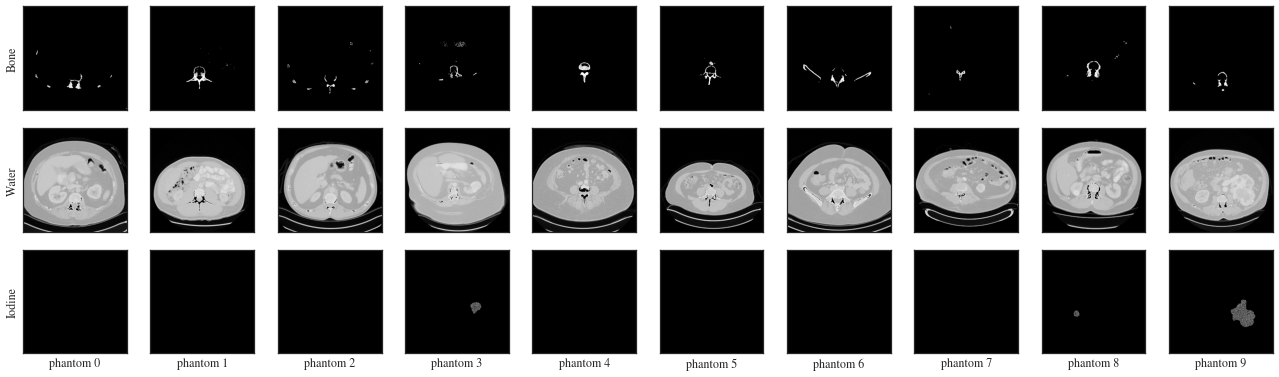

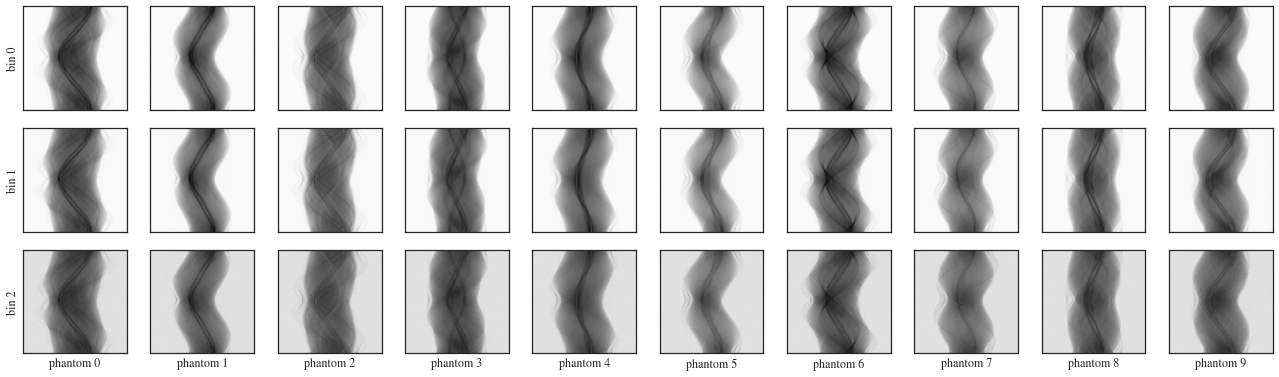

In [13]:
# Load some phantoms + measurements from the training data
nshow = 10 # Number of phantoms to show
x = torch.zeros((nshow,3,img_w,img_w))
y = torch.zeros((nshow,8,n_det,n_ang))
for i in range(nshow):
    x[i] = torch.load(ses_path + f"data_target/target_phantom_{i}.Tensor").to("cpu")
    y[i] = torch.load(ses_path + f"data_target/target_sinogram_{i}.Tensor").to("cpu")
    
# Take a look at the data
plot_image_channels(x,
                    image_labels=[f"phantom {i}" for i in range(nshow)],
                    channel_labels=["Bone", "Water", "Iodine"],
                    cmap="Greys_r",
                    vmax=1,
                    vmin=0)
    
plot_image_channels(y,
                    image_labels=[f"phantom {i}" for i in range(nshow)],
                    channel_labels=[f"bin {i}" for i in range(8)],
                    subset=[0,3,6],
                    cmap="Greys_r")


Now we are ready to create a session, let's call it `test_session`. Make sure that num_data is less than or equal to the number of tensors in the init folder. If the init process fails, you might have to delete the two folders named `test_session`. One can be found in the `sessions` directory, and one in the `data_loading_path` directory.

In [14]:
ses = FwdBwdSession(session_name = "test_session",
                    data_loading_path = data_path,
                    session_path = ses_path,
                    learning_rate=[1e-3, 1e-3],
                    num_data=20,
                    device="cuda",
                    verbose=True,
                    validate_every_n=100,
                    save_every_n=10,
                    batch_norm=(0, 0),
                    activations=(nn.LeakyReLU, nn.LeakyReLU),
                    in_ch=(8, 8),
                    bfgs_stepsize=1.0,
                    grad_clip=(0.002, 0.002),
                    reg_scale=0.000006)

Directory already exists! Loading session ...
Creating operators...


/home/emastr/anaconda3/envs/odl_torch/lib/python3.9/site-packages/scipy/sparse/sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")


Creating corrective nets...
Preparing data ...
Found 20 data points. Returning data object.
Loading closest checkpoint, 1
Done loading states.


## Reconstruction

Next, we need to generate initial guesses for training. In this work, we generate guesses using a one-step method with the approximate forward operator and bfgs.

In [ ]:
y = ses.get_y_true(8).to("cuda")
ptm = [ses.get_x_true(8).to("cuda")]
losses = []

regpars = 10**(np.linspace(-6.5, -5,8))
for i,regpar in enumerate(regpars):
    print(f"{i} out of 10 done")
    x = torch.zeros((1,3,256,256)).to("cuda")
    ses.reg_scale=regpar
    #grad = lambda x: ses.loss_gradient_autograd(x, ses.fwd_acc, y)
    grad = lambda x: ses.loss_gradient(x, ses.fwd_apx, ses.bwd_apx, y)
    
    loss = []
    def callback(x, i, ss, ys):
        loss.append(ss[-1].norm())
        
    x, _, _ = ses.bfgs_steps(x, grad, ses.phantom_inner, step=1.0, iter=5000, num_store=10, verbose=True, logger=None, callback=callback)
    
    losses.append(loss)
    ptm.append(x.to("cpu"))

0 out of 10 done


/home/emastr/anaconda3/envs/odl_torch/lib/python3.9/site-packages/scipy/sparse/sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")


1 out of 10 doneions


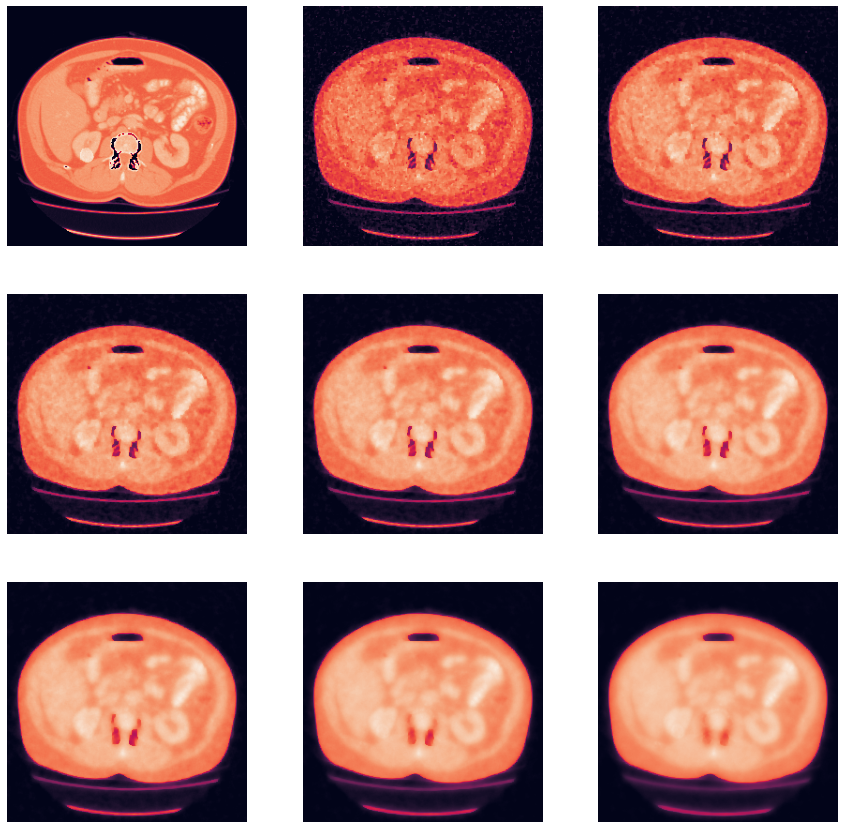

In [35]:
ptm_np = [p.detach().cpu().numpy() for p in ptm]
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(ptm_np[i][0,1,:,:], vmin=0)
    plt.title(10**regpars[i])
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.xticks([])
    plt.yticks([])

There is no clear best choice, but $6\times 10^{-6}$ looks decent. Now that we are confident in a good regularisation parameter, we generate training data by running 4000 steps of the approximate forward operator. This is sure to give us the best possible initialisation. After generating, we store this data for training.

In [48]:
ntrain = 100
ntest = 100
nsecret = 100

img_w = 256
n_det = 512
n_ang = 512
    

def save_initial_data(niter=4000):
    
    class Callback():
        def __init__(self, name):
            self.counter=0
            self.name=name

        def __call__(self, *args):
            if self.counter % 10 == 0:
                print(f"Phantom {self.name}/{ntrain}: {self.counter}/{niter} iterations done.", end="\r")
            self.counter += 1


    regpars = 10**(np.linspace(-6.5, -5,8))
    ses.reg_scale=regpars[3] # 5th choice is good

    #sinograms = torch.zeros(ntrain, 8, n_det, n_ang)

    path=ses_path + "/data_target/"
    # Iterate through existing phantoms and generate noisy measurements.
    for i in range(ntrain):
        # Load data
        y = torch.load(f"{path}target_sinogram_{i}.Tensor").to("cuda")
        x0 = torch.zeros(1,3,img_w, img_w).to("cuda")

        grad = lambda x: ses.loss_gradient(x, ses.fwd_apx, ses.bwd_apx, y)
        x,_,_ = ses.bfgs_steps(x_init, 
                                   grad, 
                                   ses.phantom_inner, 
                                   step=1.0, 
                                   iter=niter, 
                                   num_store=10, 
                                   verbose=False,
                                   callback=Callback(i))


        torch.save(x, ses_path + f"/data_init/phantom_{i}.Tensor")

In [ ]:
save_initial_data(4000)

We are now prepared to train a model on this data. See `TUT_kits_training.ipynb` for a guide to training.